```yaml
#%mldev nb_context

pipeline:
  - imports
  - device
  - params
  - mkdir
  - train_test_data
  - def_VarLayer
  - def_lot_of_classes
  - def_VarSeqNet
  - def_train_batches
  - train_batches
  - more_train_batches
  - def_funcs
  - net
  - lamb_results
  - write_results_file
  - plot
  - def_copy
  - lam_results_2
  - write_results_lowrank
  - plot_2
  - third_results
  - write_results_linear
  - plot_linear
  - lam_results_3
  - results_lowrank_finetune
  - plot_4
  - lam_results_4
  - new_results_linear
  - plot_resluts_linear
  - train_batches_again
  - save_results
  - save_results_1e
  - plot_results_1e
  - check_all_results
  - calc_stab
  - ordinal_model
  - 1e_model
  - lr_model
  - linear_model
  - batches
  - new_plots
  - last_plots

```

In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
# %matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os

#%mldev imports

In [2]:
device = 'cpu:0' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
#%mldev device

In [3]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 10 #количество эпох
lamb = [0.1, 1,  10, 100]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 1


lam_hidden_num = 50
lambda_sample_num = 5
path_to_save = 'saved'

#%mldev params

In [4]:
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

#%mldev mkdir

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)

#%mldev train_test_data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
#%mldev def_VarLayer

In [7]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1))

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 

        
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

#%mldev def_lot_of_classes

In [8]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    
#%mldev def_VarSeqNet

In [9]:
def train_batches(net, loss_fn, optimizer, lam, label):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*3 -1
                lam_param = 10**p[0]
                
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, lam_param/100.0)
                loss = loss + loss_fn(out, y)/lambda_sample_num
                loss += net.KLD(lam_param/100.0)*lam_param/len(train_data)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
        else:
            out = net(x)
            loss = loss + loss_fn(out, y)
            loss += net.KLD()*lam/len(train_data)
            losses+=[loss.cpu().detach().numpy()]
        tq.set_description(label+str(np.mean(losses)))
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()

#%mldev def_train_batches

In [10]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))
#%mldev train_batches

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
lambda 100, epoch 9: 2.1479433: 100%|██████████| 938/938 [00:22<00:00, 41.29it/s]


In [11]:
for mode in ['lowrank', 'linear']:
    t.manual_seed(0)
    for start in range(start_num): 
        if mode == 'lowrank':
            net = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
        else:
            net = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
            
        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = '{}, epoch {}: '.format(mode, e)                
            train_batches(net, loss_fn, optim, None, label)
        t.save(net.state_dict(), os.path.join(path_to_save, '{}_start_{}.cpk'.format(mode, start)))

#%mldev more_train_batches

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
lowrank, epoch 9: 0.579878: 100%|██████████| 938/938 [01:09<00:00, 13.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.x

In [12]:
def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval()
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc


# будем удалять по 10% от модели и смотреть качество
def delete_10(net):
    acc_delete = []
    mu = net[0].mean
    sigma = t.exp(2*net[0].log_sigma)
    prune_coef = (mu**2/sigma).cpu().detach().numpy()    
    sorted_coefs = np.sort(prune_coef.flatten())
    mu2 = net[1].mean
    sigma2 = t.exp(2*net[1].log_sigma)
    prune_coef2 = (mu2**2/sigma2).cpu().detach().numpy()    
    sorted_coefs2 = np.sort(prune_coef2.flatten())
    
    
    for j in range(10):
        
        ids = (prune_coef <= sorted_coefs[round(j/10*len(sorted_coefs))]) 
        net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
        
        ids2 = (prune_coef2 <= sorted_coefs2[round(j/10*len(sorted_coefs2))]) 
        net[1].mean.data*=(1-t.tensor(ids2*1.0, device=device, dtype=t.float))
        
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(net))
    return acc_delete    

#%mldev def_funcs

In [13]:
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)

#%mldev net

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


In [14]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))
#%mldev lamb_results

0.1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
10 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
100 0
nonzero params:  te

In [15]:
import json
with open('results_var.json','w') as out:
    out.write(json.dumps(lam_results))

#%mldev write_results_file

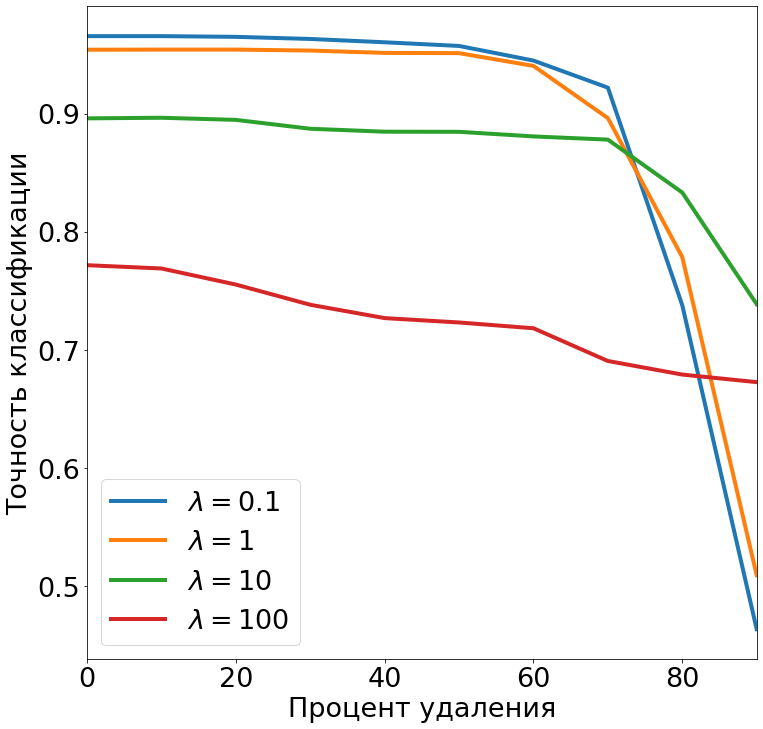

In [16]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()

#%mldev plot

In [17]:
def net_copy(net, new_net, lam):
    lam_param = lam/100.0
    for j in range(0, 2): # бежим по слоям        
        new_net[j].mean.data*=0
        new_net[j].mean.data+=net[j].mean(lam_param)
        new_net[j].mean_b.data*=0
        new_net[j].mean_b.data+=net[j].mean_b(lam_param)
        new_net[j].log_sigma.data*=0
        new_net[j].log_sigma.data+=net[j].log_sigma(lam_param)
        new_net[j].log_sigma_b.data*=0
        new_net[j].log_sigma_b.data+=net[j].log_sigma_b(lam_param)
    
#%mldev def_copy

In [18]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

#%mldev lam_results_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
10 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
100 0
nonzero params:  te

In [19]:
import json
with open('results_lowrank.json','w') as out:
    out.write(json.dumps(lam_results))

#%mldev write_results_lowrank

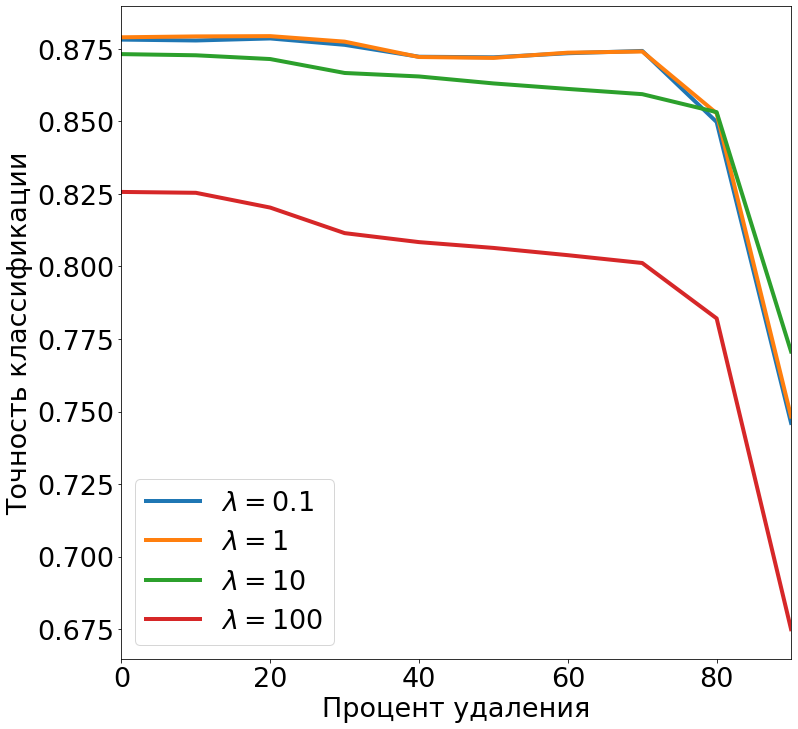

In [20]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()

#%mldev plot_2

In [21]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

#%mldev third_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
10 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
100 0
nonzero params:  te

In [22]:
import json
with open('results_linear.json','w') as out:
    out.write(json.dumps(lam_results))

#%mldev write_results_linear

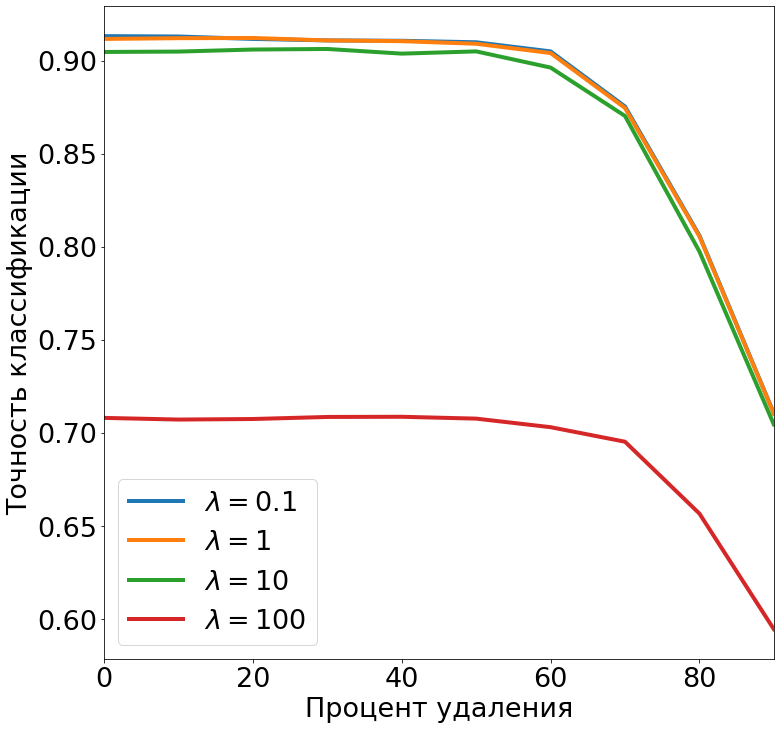

In [23]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()

#%mldev plot_linear

In [24]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
t.manual_seed(0)
for lam in lamb:    
    lam_results[lam] = []
    for s in range(start_num):
        
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune lowrank, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        
#%mldev lam_results_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
finetune lowrank, lam:0.1 0.46290913: 100%|██████████| 93

nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune lowrank, lam:1 0.37523943: 100%|██████████| 938/938 [00:21<00:00, 44.38it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune lowrank, lam:10 0.62488914: 100%|██████████| 938/938 [00:21<00:00, 44.28it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune lowrank, lam:100 1.4857925: 100%|██████████| 938/938 [00:21<00:00, 44.30it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


In [25]:
import json
with open('results_lowrank_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

#%mldev results_lowrank_finetune

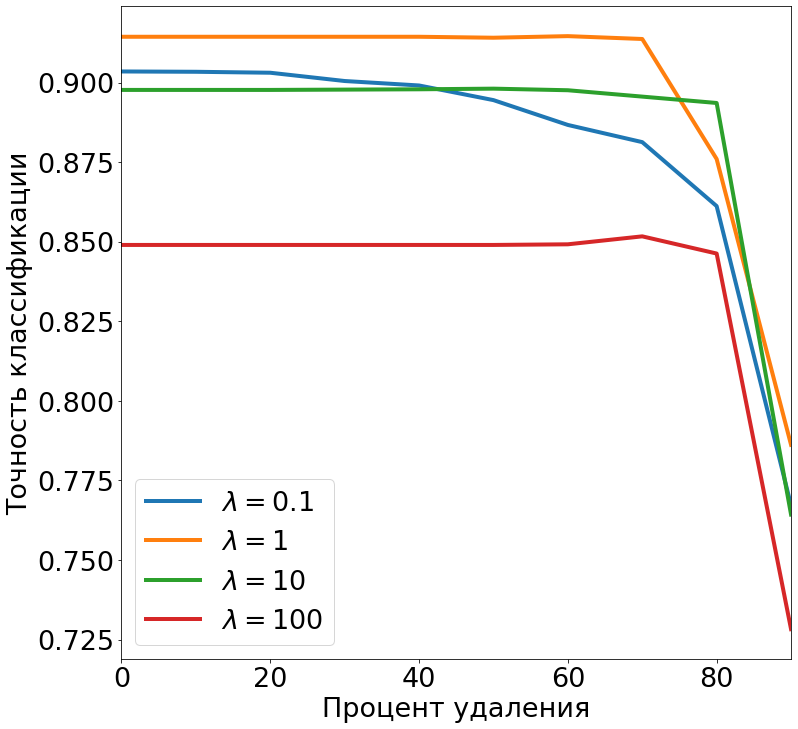

In [26]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


#%mldev plot_4

In [27]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
t.manual_seed(0)    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune linear, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        
#%mldev lam_results_4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
finetune linear, lam:0.1 0.39203674: 100%|██████████| 938/938 [00:23<00:00, 40.32it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune linear, lam:1 0.2911772: 100%|██████████| 938/938 [00:21<00:00, 43.00it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune linear, lam:10 0.60780686: 100%|██████████| 938/938 [00:22<00:00, 42.49it/s]


nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


finetune linear, lam:100 1.6393541: 100%|██████████| 938/938 [00:22<00:00, 42.06it/s]


nonzero params:  tensor(0.9797)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)


In [28]:
import json
with open('results_linear_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

#%mldev new_results_linear

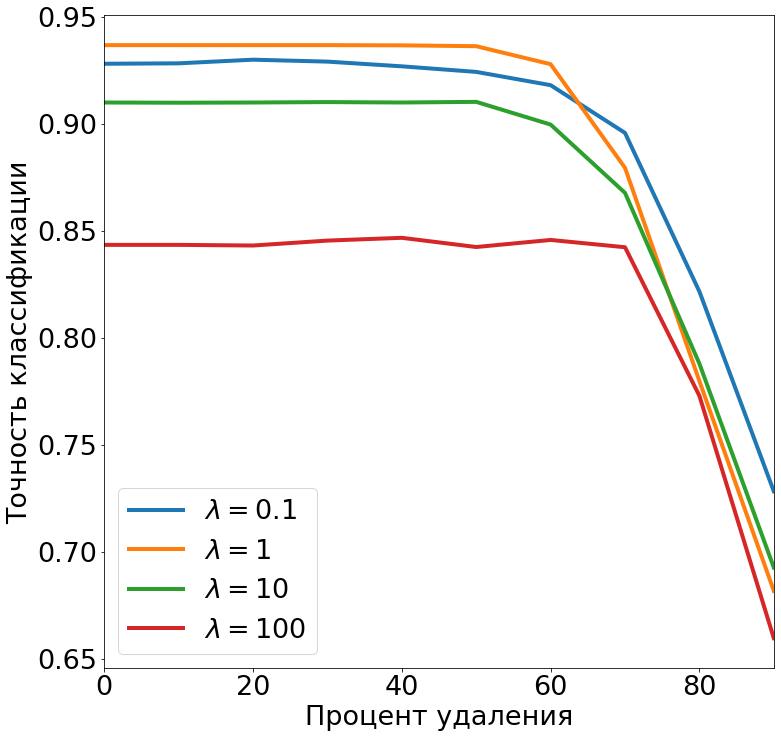

In [29]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


#%mldev plot_resluts_linear

In [30]:
for lam in lamb:
    t.manual_seed(0) 
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)                        
            label = 'lambda {} '.format(lam)                
            train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, start)))

#%mldev train_batches_again

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
lambda 100 20.829199: 100%|██████████| 938/938 [00:22<00:00, 42.30it/s]


In [31]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))
#%mldev save_results

0.1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
1 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
10 0
nonzero params:  tensor(1.0000)
nonzero params:  tensor(0.9000)
nonzero params:  tensor(0.8000)
nonzero params:  tensor(0.7000)
nonzero params:  tensor(0.6000)
nonzero params:  tensor(0.5000)
nonzero params:  tensor(0.4000)
nonzero params:  tensor(0.3000)
nonzero params:  tensor(0.2000)
nonzero params:  tensor(0.1000)
100 0
nonzero params:  te

In [32]:
import json
with open('results_1e.json','w') as out:
    out.write(json.dumps(lam_results))
#%mldev save_results_1e

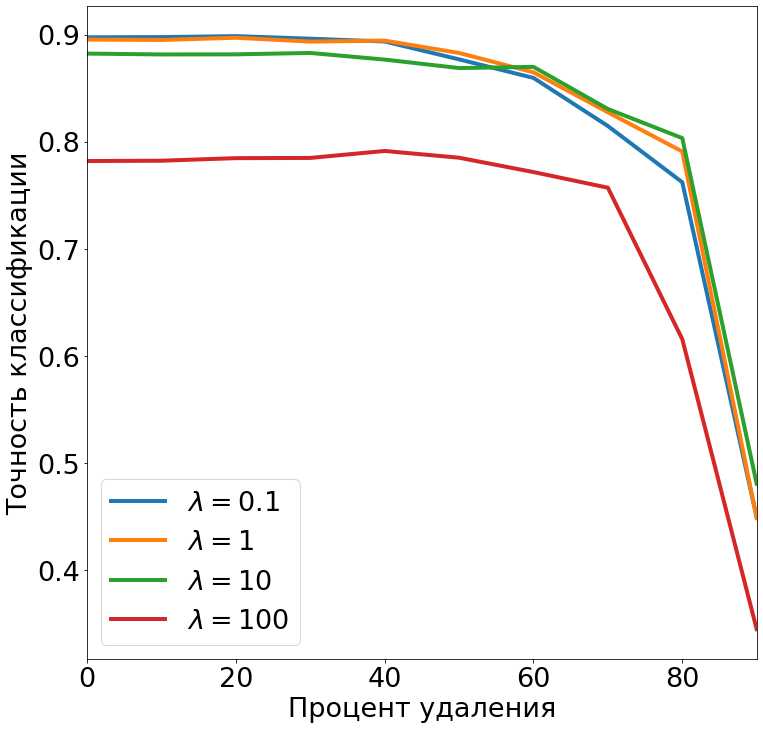

In [33]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()

#%mldev plot_results_1e

In [34]:
#calculating accuracy
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

#%mldev check_all_results

mode: results_var
0.1 0.88454 0.15511966477529532
1 0.88429 0.13546377707712126
10 0.86743 0.04628153087355689
100 0.7244900000000001 0.03357830996342729

mode: results_1e
0.1 0.8246499999999999 0.13216414982891542
1 0.8290199999999999 0.13119023439265592
10 0.82585 0.11772985390290774
100 0.7199899999999999 0.13454075553526523

mode: results_lowrank
0.1 0.85992 0.03876621725162258
1 0.86082 0.03822964294889504
10 0.8557300000000001 0.028974611300240066
100 0.79599 0.04214590015648022

mode: results_linear
0.1 0.8765499999999999 0.0637800478206155
1 0.8760200000000001 0.06368905400459328
10 0.86984 0.06380312218065821
100 0.6896500000000001 0.03513938673340785

mode: results_lowrank_finetune
0.1 0.8800500000000001 0.039689501130651665
1 0.8976600000000001 0.03886919602976115
10 0.8838000000000001 0.039855865314906924
100 0.8369500000000001 0.036236838990176844

mode: results_linear_finetune
0.1 0.8930700000000001 0.06331971336005873
1 0.8889400000000001 0.08369503211063366
10 0.87087 0

In [35]:
#calculating stability
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
        
    for lam in lamb:
        lam = str(lam)
        v_0 = np.array(data[lam])[:,0]
        v_last = np.array(data[lam])[:,-1]
        
        stab = v_0/v_last
        print (lam, np.mean(stab), np.std(stab))
    print()

#%mldev calc_stab

mode: results_var
0.1 2.082830025884383 0.0
1 1.8733555860985667 0.0
10 1.2129416542574794 0.0
100 1.1471681284376396 0.0

mode: results_1e
0.1 1.996662958843159 0.0
1 1.9955426788500112 0.0
10 1.8350665557404326 0.0
100 2.266666666666667 0.0

mode: results_lowrank
0.1 1.1770540142072108 0.0
1 1.174662568488574 0.0
10 1.1329959776826262 0.0
100 1.2232592592592593 0.0

mode: results_linear
0.1 1.2851513019000704 0.0
1 1.2834013796987187 0.0
10 1.2840312278211496 0.0
100 1.1909167367535742 0.0

mode: results_lowrank_finetune
0.1 1.1776590198123045 0.0
1 1.1630628338845077 0.0
10 1.174538793667408 0.0
100 1.1657284086228203 0.0

mode: results_linear_finetune
0.1 1.2741625480505216 0.0
1 1.3738084763161755 0.0
10 1.3135103926096998 0.0
100 1.2784177023340406 0.0



In [36]:
print ('ordinal model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
#%mldev ordinal_model

ordinal model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 11636.422167110442
1 28454.74894952774
10 67300.60690879822
100 127862.57944107056


In [37]:
print ('1e model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
#%mldev 1e_model

1e model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


0.1 31847.787357139587
1 51028.57569313049
10 189892.44519233704
100 724184.2309951782


In [38]:
print ('lr model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
#%mldev lr_model

lr model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0.1 32748.416359710693
1 35721.01872253418
10 58386.29849433899


lambda 100 0.53805435:   1%|          | 5/938 [00:00<00:19, 46.66it/s]

100 184449.08323287964
lr ft model


lambda 100 0.5866074:   1%|          | 5/938 [00:00<00:19, 46.79it/s] 

0.1 25674.737982940675


lambda 100 0.9470822:   1%|          | 5/938 [00:00<00:20, 44.87it/s]

1 30339.555904388428


lambda 100 3.106627:   1%|          | 5/938 [00:00<00:20, 44.47it/s] 

10 57720.34362792969


lambda 100 2.421834: 100%|██████████| 938/938 [00:22<00:00, 41.24it/s]


100 139647.32370376587


In [39]:
print ('linear model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
#%mldev linear_model   

linear model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0.1 26009.872548484804
1 30307.931462287903
10 65435.2241230011


lambda 100 0.40790287:   1%|          | 5/938 [00:00<00:19, 47.26it/s]

100 219454.20665740967
lr ft model


lambda 100 0.46746227:   1%|          | 5/938 [00:00<00:20, 45.25it/s]

0.1 21276.391169166563


lambda 100 1.0660293:   1%|          | 5/938 [00:00<00:21, 42.59it/s]

1 27620.042120933533


lambda 100 3.6026683:   1%|          | 5/938 [00:00<00:20, 45.41it/s]

10 62135.320167541504


lambda 100 2.6037238: 100%|██████████| 938/938 [00:22<00:00, 42.41it/s]


100 139354.55255508423


In [40]:
# количество оптимизаций параметров
# количество батчей * количество эпох * количество параметров, домноженное на количество элементов в lamb
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in net.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
p_num_var = p_num

print ('ordinal', len(train_loader)*epoch_num*(p_num)*len(lamb))
print ('1e', len(train_loader)*p_num * len(lamb))

hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('low rank', len(train_loader)*epoch_num*(p_num))
print ('low rank finetune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('linear', len(train_loader)*epoch_num*(p_num))
print ('linear fine tune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

#%mldev batches

ordinal 2983590400
1e 298359040
low rank 1666150640
low rank finetune 1740740400
linear 1491795200
linear fine tune 1566384960


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

In [41]:
#new plots
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

#%mldev new_plots

mode: results_var
0.1 0.88454 0.15511966477529532
1 0.88429 0.13546377707712126
10 0.86743 0.04628153087355689
100 0.7244900000000001 0.03357830996342729

mode: results_1e
0.1 0.8246499999999999 0.13216414982891542
1 0.8290199999999999 0.13119023439265592
10 0.82585 0.11772985390290774
100 0.7199899999999999 0.13454075553526523

mode: results_lowrank
0.1 0.85992 0.03876621725162258
1 0.86082 0.03822964294889504
10 0.8557300000000001 0.028974611300240066
100 0.79599 0.04214590015648022

mode: results_linear
0.1 0.8765499999999999 0.0637800478206155
1 0.8760200000000001 0.06368905400459328
10 0.86984 0.06380312218065821
100 0.6896500000000001 0.03513938673340785

mode: results_lowrank_finetune
0.1 0.8800500000000001 0.039689501130651665
1 0.8976600000000001 0.03886919602976115
10 0.8838000000000001 0.039855865314906924
100 0.8369500000000001 0.036236838990176844

mode: results_linear_finetune
0.1 0.8930700000000001 0.06331971336005873
1 0.8889400000000001 0.08369503211063366
10 0.87087 0

mode: results_var
mode: results_1e
mode: results_lowrank
mode: results_lowrank_finetune
mode: results_linear
mode: results_linear_finetune


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


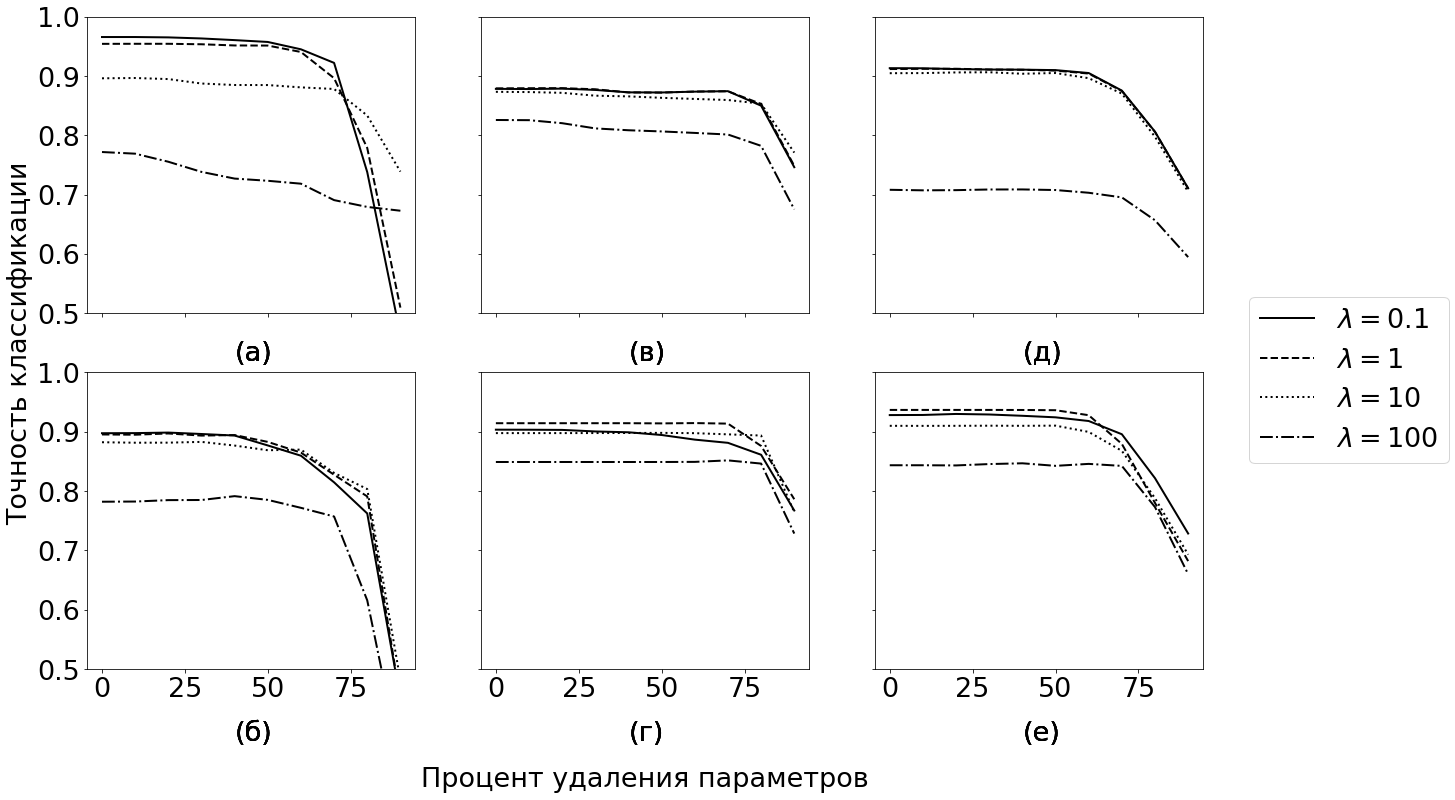

In [42]:
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
fig, axs = plt.subplots(2, 3)
coords = [(0,0), (1,0), (0,1), (1,1), (0,2), (1,2)]
titles = ['(а)', '(б)', '(в)', '(г)', '(д)', '(е)']
ls = {
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
roc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var','results_1e', 'results_lowrank', 'results_lowrank_finetune', 'results_linear', 'results_linear_finetune']):
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]
    p


    for lam in lamb:
        lam = str(lam)
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
        current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
                            yerr = np.std(lam_results[lam], 0), 
                            ls = ls[lam],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
                       lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 5:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления параметров', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
#plt.autoscale(enable=True, axis='x', tight=False)
#fig.tight_layout()
plt.savefig('hypernets.eps', bbox_inches = 'tight')
#plt.show()

#%mldev last_plots